# Parte técnica - Projeto Redes Sociais

## Feito por: Gabriel Kabbani, Luis Filipe Loureiro e Murilo Menezes

In [45]:
from graph_tool import centrality, clustering, Graph
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set()
import netpixi
from netpixi.data.gt import *
from itertools import combinations
import csv
import cpnet
from graph_tool import spectral
import matplotlib.pyplot as plt

In [2]:


lista_rows=[]
anos=['2016','2017','2018','2019','2020']

df = pd.read_csv('camara_municipal_sp_sessoes_12_20.csv')

indexes_to_drop = []


for i, r in df.iterrows():
    if r['data'][6:10] not in anos or 'PL' not in r['materia']:
        indexes_to_drop.append(i)

clean_df = df.drop(df.index[indexes_to_drop]).dropna()



In [3]:
clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020


In [4]:
clean_df['vereador'].value_counts()

JOSÉ POLICE NETO       223
ALFREDINHO             220
NOEMI NONATO           209
REIS                   191
RICARDO NUNES          191
                      ... 
MANOEL DEL RIO           3
RODOLFO DESPACHANTE      2
RODRIGO FONSECA          2
LUIZ PASCHOAL            1
ISA PENNA                1
Name: vereador, Length: 97, dtype: int64

In [5]:
#adicionando coluna com a posição política de cada vereador baseado no seu partido

pos_politica = {

    "PSDB" : 0.6,

    "PT" : -0.3,

    "PSD" : 0.3,

    "DEM" : 0.6,

    "PSB" : -0.1,

    "PR" : 0.1,

    "PRB" : 0.1,

    "DEMOCRATAS" : 0.6,

    "REPUBLICANOS" : 0.2,

    "MDB" : 0.4,

    "PTB" : 0.15,

    "PSOL" : -0.9,

    "PL" : 0.7,

    "PV" : -0.6,

    "PODE" : 0.3,

    "CIDADANIA" : 0.1,

    "NOVO" : 0.8,

    "PSC" : 0.4,

    "PPS" : 0.1,

    "PHS" : -0.1,

    "PP" : 0.5,

    "PROS" : 0.2,

    "PDT" : -0.6,

    "PMDB" : 0.4,

    "PATRIOTA" : 0.7,

    "PSL" : 0.6,

    "S/PARTIDO" : 0,

    "PC DO B" : -1,

    "REDE" : -0.5

}



pos_politica_col =[]

for i, r in clean_df.iterrows():
    
    pos_politica_col.append(pos_politica[r['partido']])
    
clean_df['posição política'] = pos_politica_col

clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data,posição política
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.60
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.15
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.20
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.70
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,-0.90
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.60


In [43]:
#criando coluna com tamanho do partido

tamanho_partido = {}
ver_temp = []

for i, r in clean_df.iterrows():
    if r['vereador'] not in ver_temp:
        ver_temp.append(r['vereador'])
        
        if r['partido'] not in tamanho_partido:
            tamanho_partido[r['partido']]=1
        else:
            tamanho_partido[r['partido']]+=1

tam_partido_col =[]

for i, r in clean_df.iterrows():
    #corrigindo partidos que deixaram de existir ou mudaram de nome
    if r['partido'] == 'MDB':
        tam_partido_col.append(tamanho_partido['PMDB'])
    elif r['partido'] == 'DEM':
        tam_partido_col.append(tamanho_partido['DEMOCRATAS'])
    elif r['partido'] == 'REPUBLICANOS':
        tam_partido_col.append(tamanho_partido['PR'])
    elif r['partido'] == 'PL' or r['partido'] == 'CIDADANIA' or r['partido'] == 'PATRIOTA' or r['partido'] == 'PSL' or r['partido'] == 'S/PARTIDO':
        tam_partido_col.append(0)
    else:
        tam_partido_col.append(tamanho_partido[r['partido']])
    
clean_df['tamanho partido'] = tam_partido_col

clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data,posição política,tamanho partido
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.60,7
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.15,5
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30,14
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30,14
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.30,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.20,5
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.70,0
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,-0.90,4
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.60,16


In [7]:
vereadores = []
projetos = []

for i, r in clean_df.iterrows():
    if r['vereador'] not in vereadores:
        vereadores.append(r['vereador'])
    if r['materia'] not in projetos:
        projetos.append(r['materia'])


In [8]:
g = Graph(directed=True)

g.vp['bipartite'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')

In [9]:
for _ in vereadores:
    g.add_vertex()
    
i=0
for v in g.vertices():
    g.vp['bipartite'][v]= 1
    g.vp['nome'][v]=vereadores[i]
    i+=1
    
for _ in projetos:
    g.add_vertex()
    
    
i=0
for v in g.vertices():
    if g.vp['bipartite'][v] != 1:
        g.vp['bipartite'][v]= 0
        g.vp['nome'][v]=projetos[i]
        i+=1
        
        


In [10]:
for v in g.vertices():
    print(g.vp['bipartite'][v], g.vp['nome'][v])

1 ABOU ANNI
1 ADILSON AMADEU
1 ALESSANDRO GUEDES
1 ALFREDINHO
1 ANDREA MATARAZZO
1 ANIBAL DE FREITAS FILHO
1 ANTONIO DONATO
1 ARI FRIEDENBACH
1 ARSELINO TATTO
1 ATILIO FRANCISCO
1 AURÉLIO MIGUEL
1 AURELIO NOMURA
1 CALVO
1 CLAUDINHO DE SOUZA
1 CONTE LOPES
1 DALTON SILVANO
1 DAVID SOARES
1 EDIR SALES
1 EDUARDO TUMA
1 ELISEU GABRIEL
1 FRANCISCO CHAGAS
1 GEORGE HATO
1 GILSON BARRETO
1 JAIR TATTO
1 JAMIL MURAD
1 JONAS CAMISA NOVA
1 JOSÉ POLICE NETO
1 JULIANA CARDOSO
1 MÁRIO COVAS NETO
1 MARQUITO
1 MILTON LEITE
1 NATALINI
1 NELO RODOLFO
1 NOEMI NONATO
1 OTA
1 PATRÍCIA BEZERRA
1 PAULO FIORILO
1 PAULO FRANGE
1 PR. EDEMILSON CHAVES
1 QUITO FORMIGA
1 REIS
1 RICARDO NUNES
1 RICARDO TEIXEIRA
1 RICARDO YOUNG
1 SALOMÃO PEREIRA
1 SANDRA TADEU
1 SENIVAL MOURA
1 SOUZA SANTOS
1 TONINHO PAIVA
1 TONINHO VESPOLI
1 USHITARO KAMIA
1 VALDECIR CABRABOM
1 VAVÁ
1 ADOLFO QUINTAS
1 LAÉRCIO BENKO
1 WADIH MUTRAN
1 CELSO JATENE
1 NABIL BONDUKI
1 JOSELITO
1 JEAN MADEIRA
1 RODOLFO DESPACHANTE
1 ADRIANA RAMALHO
1 ALINE 

In [11]:
save_gt(g, 'exemplo.net.gz')
#r = netpixi.render('exemplo.net.gz')

In [12]:
#utilizando o algoritmo SFDP, que utiliza force-directed graph drawing para aproximar os vértices conectados

g = load_gt('exemplo.net.gz')
m = draw_gt.sfdp_layout(g)
move_gt(g, m)
save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [13]:
g.vp['color'] = g.new_vp('object')

for v in g.vertices():
    if g.vp['bipartite'][v] == 0:
        g.vp['color'][v] = 0xff0000
    else:
        g.vp['color'][v] = 0x00ff00

save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [14]:
g.ep['voto'] = g.new_ep('object')
for v in g.vertices():
    for v2 in g.vertices():
        if g.vp['bipartite'][v] == 0 and g.vp['bipartite'][v2] == 1:
            if g.edge(v,v2)==None:
                g.add_edge(v, v2)
                row=clean_df.loc[(clean_df["vereador"] == g.vp['nome'][v2]) & (clean_df["materia"]==g.vp['nome'][v])]
                e = g.edge(v,v2)
                #print(row['voto'].tolist())
                if (row['voto'].tolist()) == ['Não']:
                    g.ep['voto'][e]=-1
                elif (row['voto'].tolist()) == ['Sim']:
                    g.ep['voto'][e]=1
                else:
                    g.ep['voto'][e]=0  

In [15]:
for i, r in clean_df.iterrows():
    print(r['vereador'])

ABOU ANNI
ADILSON AMADEU
ALESSANDRO GUEDES
ALFREDINHO
ANDREA MATARAZZO
ANIBAL DE FREITAS FILHO
ANTONIO DONATO
ARI FRIEDENBACH
ARSELINO TATTO
ATILIO FRANCISCO
AURÉLIO MIGUEL
AURELIO NOMURA
CALVO
CLAUDINHO DE SOUZA
CONTE LOPES
DALTON SILVANO
DAVID SOARES
EDIR SALES
EDUARDO TUMA
ELISEU GABRIEL
FRANCISCO CHAGAS
GEORGE HATO
GILSON BARRETO
JAIR TATTO
JAMIL MURAD
JONAS CAMISA NOVA
JOSÉ POLICE NETO
JULIANA CARDOSO
MÁRIO COVAS NETO
MARQUITO
MILTON LEITE
NATALINI
NELO RODOLFO
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FIORILO
PAULO FRANGE
PR. EDEMILSON CHAVES
QUITO FORMIGA
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RICARDO YOUNG
SALOMÃO PEREIRA
SANDRA TADEU
SENIVAL MOURA
SOUZA SANTOS
TONINHO PAIVA
TONINHO VESPOLI
USHITARO KAMIA
VALDECIR CABRABOM
VAVÁ
ADILSON AMADEU
ADOLFO QUINTAS
ALESSANDRO GUEDES
ALFREDINHO
ANDREA MATARAZZO
ANIBAL DE FREITAS FILHO
ANTONIO DONATO
ARI FRIEDENBACH
ARSELINO TATTO
AURÉLIO MIGUEL
AURELIO NOMURA
CLAUDINHO DE SOUZA
CONTE LOPES
DALTON SILVANO
DAVID SOARES
EDIR SALES
EDUARDO TUMA


PR. EDEMILSON CHAVES
RICARDO TEIXEIRA
SALOMÃO PEREIRA
SANDRA TADEU
SENIVAL MOURA
TONINHO PAIVA
VAVÁ
ABOU ANNI
ADILSON AMADEU
ADOLFO QUINTAS
ALFREDINHO
ANDREA MATARAZZO
ANIBAL DE FREITAS FILHO
ANTONIO DONATO
ARI FRIEDENBACH
ARSELINO TATTO
ATILIO FRANCISCO
AURÉLIO MIGUEL
AURELIO NOMURA
CALVO
CELSO JATENE
CLAUDINHO DE SOUZA
CONTE LOPES
DALTON SILVANO
EDUARDO TUMA
ELISEU GABRIEL
JAIR TATTO
JAMIL MURAD
JEAN MADEIRA
JONAS CAMISA NOVA
JOSÉ POLICE NETO
MILTON LEITE
NATALINI
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FIORILO
PAULO FRANGE
PR. EDEMILSON CHAVES
RICARDO NUNES
RICARDO TEIXEIRA
SALOMÃO PEREIRA
SENIVAL MOURA
SOUZA SANTOS
TONINHO PAIVA
TONINHO VESPOLI
VAVÁ
ABOU ANNI
ADILSON AMADEU
ADOLFO QUINTAS
ALFREDINHO
ANIBAL DE FREITAS FILHO
ANTONIO DONATO
ARI FRIEDENBACH
ARSELINO TATTO
ATILIO FRANCISCO
AURÉLIO MIGUEL
CALVO
CELSO JATENE
CLAUDINHO DE SOUZA
CONTE LOPES
DALTON SILVANO
EDUARDO TUMA
ELISEU GABRIEL
JAIR TATTO
JAMIL MURAD
JEAN MADEIRA
JONAS CAMISA NOVA
JOSÉ POLICE NETO
MÁRIO COVAS NETO
MILT

EDUARDO TUMA
FABIO RIVA
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JANAÍNA LIMA
JANAÍNA LIMA
JOÃO JORGE
JOÃO JORGE
MILTON FERREIRA
MILTON LEITE
NOEMI NONATO
OTA
PAULO FRANGE
JOSÉ POLICE NETO
JOSÉ POLICE NETO
JOSÉ POLICE NETO
JOSÉ POLICE NETO
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RINALDI DIGILIO
RODRIGO GOULART
RUTE COSTA
SONINHA FRANCINE
TONINHO PAIVA
TONINHO VESPOLI
ZÉ TURIN
ZÉ TURIN
ABOU ANNI
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ALINE CARDOSO
ANDRÉ SANTOS
ANDRÉ SANTOS
ANDRÉ SANTOS
ANTONIO DONATO
ARSELINO TATTO
ATÍLIO FRANCISCO
ATÍLIO FRANCISCO
AURÉLIO NOMURA
AURÉLIO NOMURA
CAIO MIRANDA CARNEIRO
CAMILO CRISTÓFARO
CLAUDIO FONSECA
CONTE LOPES
DALTON SILVANO
EDIR SALES
EDUARDO MATARAZZO SUPLICY
EDUARDO TUMA
FABIO RIVA
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JANAÍNA LIMA
JANAÍNA LIMA
JOÃO JORGE
JOÃO JORGE
MILTON FERREIRA
MILTON LEITE
NOEMI NONATO
OTA
PAULO FRANGE
JOSÉ POLICE NETO
JOSÉ POLICE NETO
JOSÉ POLICE NETO
JOS

JAIR TATTO
JANAÍNA LIMA
JOÃO JORGE
MARIO COVAS NETO
MILTON FERREIRA
MILTON LEITE
NOEMI NONATO
OTA
PAULO FRANGE
JOSÉ POLICE NETO
REIS
RICARDO TEIXEIRA
RODRIGO GOULART
RUTE COSTA
SANDRA TADEU
SENIVAL MOURA
SONINHA FRANCINE
TONINHO PAIVA
TONINHO VESPOLI
REGINALDO TRÍPOLI
ADILSON AMADEU
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ANTONIO DONATO
ARSELINO TATTO
ATÍLIO FRANCISCO
AURÉLIO NOMURA
CAMILO CRISTÓFARO
CELSO JATENE
CLAUDINHO DE SOUZA
CLAUDIO FONSECA
CONTE LOPES
DALTON SILVANO
EDIR SALES
EDUARDO MATARAZZO SUPLICY
EDUARDO TUMA
ELISEU GABRIEL
FABIO RIVA
FERNANDO HOLIDAY
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JAIR TATTO
JANAÍNA LIMA
JOÃO JORGE
JULIANA CARDOSO
MILTON FERREIRA
MILTON LEITE
GILBERTO NATALINI
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FRANGE
JOSÉ POLICE NETO
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RODRIGO GOULART
RUTE COSTA
SÂMIA BOMFIM
SANDRA TADEU
SENIVAL MOURA
SONINHA FRANCINE
SOUZA SANTOS
TONINHO PAIVA
TONINHO VESPOLI
REGINALDO TRÍPOLI
ZÉ TURIN
ADRIANA RAMALHO
ALFREDINH

NATALINI
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FRANGE
QUITO FORMIGA
REIS
RICARDO NUNES
RINALDI DIGILIO
RODRIGO GOULART
RUTE COSTA
SÂMIA BOMFIM
SÂMIA BOMFIM
SANDRA TADEU
SONINHA FRANCINE
SOUZA SANTOS
TONINHO PAIVA
REGINALDO TRIPOLI
ZÉ TURIN
ALESSANDRO GUEDES
ALFREDINHO
AMAURI SILVA
ANTONIO DONATO
ATÍLIO FRANCISCO
AURÉLIO NOMURA
CAIO MIRANDA CARNEIRO
CELSO JATENE
CLAUDINHO DE SOUZA
CLAUDIO FONSECA
DALTON SILVANO
EDIR SALES
EDUARDO MATARAZZO SUPLICY
FABIO RIVA
FERNANDO HOLIDAY
GEORGE HATO
GILSON BARRETO
JANAÍNA LIMA
JOÃO JORGE
JOSÉ POLICE NETO
JULIANA CARDOSO
MILTON FERREIRA
MILTON LEITE
NATALINI
NOEMI NONATO
PAULO FRANGE
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RINALDI DIGILIO
RUTE COSTA
SENIVAL MOURA
SONINHA FRANCINE
SOUZA SANTOS
TONINHO PAIVA
REGINALDO TRIPOLI
ZÉ TURIN
ALESSANDRO GUEDES
ALFREDINHO
AMAURI SILVA
ANTONIO DONATO
ATÍLIO FRANCISCO
AURÉLIO NOMURA
CAIO MIRANDA CARNEIRO
CAIO MIRANDA CARNEIRO
CELSO JATENE
CLAUDINHO DE SOUZA
CLAUDIO FONSECA
CONTE LOPES
EDIR SALES
EDUARDO MATARAZZO S

RICARDO NUNES
RICARDO TEIXEIRA
RINALDI DIGILIO
RODRIGO GOULART
SANDRA TADEU
SONINHA FRANCINE
SOUZA SANTOS
TONINHO PAIVA
TONINHO VESPOLI
ZÉ TURIN
ADILSON AMADEU
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ANTONIO DONATO
ATÍLIO FRANCISCO
AURÉLIO NOMURA
BETO DO SOCIAL
CAIO MIRANDA CARNEIRO
CAMILO CRISTÓFARO
CELSO JATENE
CLAUDINHO DE SOUZA
CLAUDIO FONSECA
EDIR SALES
EDUARDO TUMA
ELISEU GABRIEL
FABIO RIVA
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JANAÍNA LIMA
JONAS CAMISA NOVA
JOSÉ POLICE NETO
JULIANA CARDOSO
MARIO COVAS NETO
MILTON FERREIRA
MILTON LEITE
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FRANGE
QUITO FORMIGA
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RINALDI DIGILIO
RODRIGO GOULART
RUTE COSTA
SANDRA TADEU
SONINHA FRANCINE
SOUZA SANTOS
TONINHO PAIVA
ZÉ TURIN
ADILSON AMADEU
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ANTONIO DONATO
ATÍLIO FRANCISCO
BETO DO SOCIAL
CAIO MIRANDA CARNEIRO
CAIO MIRANDA CARNEIRO
CELSO GIANNAZI
CLAUDINHO DE SOUZA
CLAUDIO FONSECA
EDI

PATRÍCIA BEZERRA
PAULO FRANGE
QUITO FORMIGA
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RINALDI DIGILIO
RUTE COSTA
SANDRA TADEU
SONINHA FRANCINE
SOUZA SANTOS
TONINHO VESPOLI
ZÉ TURIN
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ARSELINO TATTO
CAIO MIRANDA CARNEIRO
CELSO GIANNAZI
CELSO JATENE
CLAUDIO FONSECA
DANIEL ANNENBERG
EDIR SALES
EDUARDO MATARAZZO SUPLICY
EDUARDO TUMA
FABIO RIVA
FERNANDO HOLIDAY
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JAIR TATTO
JANAÍNA LIMA
JOÃO JORGE
JOSÉ POLICE NETO
JULIANA CARDOSO
MARIO COVAS NETO
MILTON FERREIRA
NOEMI NONATO
PATRÍCIA BEZERRA
QUITO FORMIGA
REIS
RICARDO NUNES
RICARDO TEIXEIRA
RODRIGO GOULART
SANDRA TADEU
SONINHA FRANCINE
ZÉ TURIN
ADRIANA RAMALHO
ALFREDINHO
ARSELINO TATTO
AURÉLIO NOMURA
CAIO MIRANDA CARNEIRO
CELSO GIANNAZI
CELSO JATENE
CLAUDIO FONSECA
DANIEL ANNENBERG
EDUARDO MATARAZZO SUPLICY
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JAIR TATTO
JANAÍNA LIMA
JOÃO JORGE
JOSÉ POLICE NETO
JULIANA CARDOSO
MILTON FERREI

TONINHO VESPOLI
XEXÉU TRIPOLI
ZÉ TURIN
ADILSON AMADEU
ALESSANDRO GUEDES
ALFREDINHO
ARSELINO TATTO
ATÍLIO FRANCISCO
CAMILO CRISTÓFARO
CELSO JATENE
CLAUDIO FONSECA
DANIEL ANNENBERG
EDUARDO MATARAZZO SUPLICY
EDUARDO TUMA
ELISEU GABRIEL
FABIO RIVA
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JANAÍNA LIMA
JOÃO JORGE
JOSÉ POLICE NETO
JULIANA CARDOSO
MILTON FERREIRA
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FRANGE
QUITO FORMIGA
REIS
RICARDO NUNES
RODRIGO GOULART
SONINHA FRANCINE
TONINHO VESPOLI
XEXÉU TRIPOLI
ZÉ TURIN
ADILSON AMADEU
ADRIANA RAMALHO
ALESSANDRO GUEDES
ALFREDINHO
ARSELINO TATTO
ATÍLIO FRANCISCO
CAIO MIRANDA CARNEIRO
CAMILO CRISTÓFARO
CLAUDIO FONSECA
DANIEL ANNENBERG
EDIR SALES
EDUARDO MATARAZZO SUPLICY
EDUARDO TUMA
ELISEU GABRIEL
FERNANDO HOLIDAY
GEORGE HATO
GILBERTO NASCIMENTO
GILSON BARRETO
ISAC FELIX
JANAÍNA LIMA
JOÃO JORGE
JOSÉ POLICE NETO
JULIANA CARDOSO
MILTON FERREIRA
NOEMI NONATO
OTA
PATRÍCIA BEZERRA
PAULO FRANGE
QUITO FORMIGA
RICARDO NUNES
ROD

In [16]:
save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [17]:
produto_ver_projeto = len(vereadores)*len(projetos)
print('Vereadores vezes projetos: {}'.format(produto_ver_projeto))

Vereadores vezes projetos: 20855


In [18]:
#conferindo se numero de edges ta certo
cont=0
for e in g.edges():
    cont+=1
print(cont==produto_ver_projeto)

True


In [19]:
#verificando valor das edges
for e in g.edges():
    print(g.ep['voto'][e])

-1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
-1
-1
1
-1
1
1
-1
0
1
1
0
1
1
-1
1
-1
1
0
-1
0
0
-1
0
1
1
-1
1
-1
1
0
1
-1
0
0
-1
-1
-1
1
-1
1
0
1
1
-1
-1
0
-1
0
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
1
1
0
0
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
1
-1
0
-1
-1
1
-1
0
-1
1
-1
0
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
1
-1
0
-1
-1
0
-1
-1
0
0
-1
-1
-1
-1
-1
0
-1
1
-1
-1
-1
0
-1
0
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
0
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
0
0
1
0
0
0
0
0
0
1
1
1
0
1
1
0
0
1
1
0
0
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
1
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
1
0
1
1
-1
1
0
1
1
1
1
0
1
1
1
-1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
0
-1
0
0
-1
-1
0
0
0
-1
1
0
0
-1
0
0
-1
-1
0
0
-1
0
-1
0
-1
0
0
0
-1
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
-1
0
0
-1
1
-1
-1
-1
-1
0
-1
-1
0
0
0
-1
-1
-1
-1
0
-1
0
-1
0
0
0
0
0
0
0
0
0
0
1
1
-1
-1
0
0
-1
0
0
0
0
0
0
1
1
1
0
1
1
0
0
1
1
-1
0
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
-1
1
1
0
0
1
0
0
1
-1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
0
0
-1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
1
1
-1
-1
0
0
-1
0
0
0
0
0
0
1
1
1
0
1
1
0
0
1
1
-1
0
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
-1
1
1
0
0
1
0
0
1
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
0
-1
1
1
1
1
1
1
1
0
0
-1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
1
1
0
-1
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
0
0
0
1
0
0
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
0
0
0
0
1
1
1
1
1
0

0
0
0
1
0
0
0
-1
0
0
-1
-1
-1
0
-1
0
-1
0
-1
-1
0
0
-1
0
-1
-1
0
0
0
0
0
0
0
-1
0
0
0
0
-1
0
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
0
-1
-1
0
1
0
0
-1
-1
-1
-1
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
-1
0
1
0
0
1
0
1
0
0
0
0
-1
-1
-1
-1
-1
0
0
0
0
-1
1
0
0
1
0
0
0
-1
0
0
-1
-1
-1
0
-1
0
-1
1
-1
-1
0
0
-1
0
-1
-1
0
0
0
0
0
0
0
-1
0
0
0
0
-1
0
-1
-1
0
-1
-1
0
1
-1
0
-1
0
-1
0
0
-1
0
0
0
-1
-1
0
-1
0
1
0
0
-1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
1
1
1
1
0
1
0
0
1
1
0
0
-1
0
0
0
1
0
0
1
1
1
0
-1
0
1
1
1
1
0
0
1
0
0
1
-1
0
0
0
0
0
0
1
0
0
0
0
1
0
1
0
0
0
0
-1
-1
1
-1
1
0
1
0
0
1
-1
0
1
1
1
0
0
0
-1
0
1
1
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
1
1
0
1
1
1
1
1
1
0
1
1
0
1
0
0
1
1
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
1
1
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
1
1
1
1
1
1
1
0
1
0
1
0
0
1
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
-

1
-1
1
0
0
1
0
-1
0
0
-1
0
0
0
0
0
0
1
0
1
0
1
1
-1
0
1
1
0
0
0
0
-1
0
0
1
0
0
1
0
1
0
1
0
1
-1
0
1
0
0
1
0
1
0
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
-1
-1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
0
1
1
0
0
0
0
1
0
-1
1
0
0
-1
1
1
0
0
1
0
0
0
0
0
0
-1
0
-1
0
-1
-1
0
0
-1
-1
0
0
0
1
1
0
0
-1
0
0
-1
0
-1
0
-1
0
-1
1
0
-1
0
0
-1
0
-1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
-1
0
-1
0
0
-1
-1
-1
-1
-1
-1
-1
0
-1
0
0
0
-1
-1
-1
-1
0
0
-1
0
0
0
0
-1
0
0
-1
0
0
1
-1
-1
0
0
-1
0
0
0
0
0
0
1
0
1
0
1
1
1
0
1
1
-1
0
0
1
-1
0
0
1
0
0
1
1
1
0
0
0
1
-1
1
1
0
0
0
-1
1
1
-1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
0
1
0
0
0
0
0
1
0
-1
1
0
0
1
1
1
0
0
1
0
0
0
0
0
0
1
0
1
0
0
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
0
1
0
1
0
1
0
0
1
0
0
1
1
1
1
1
0
1
0
0
0
0
0
1
0
1
1
0
0
1
1
1
0
0
1
0
0
0
0
0
0
1
0
1
0
0
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
0
1
1
1
0
1
0
0
0
0
0
1
1

0
0
1
0
0
1
-1
1
0
1
0
1
0
1
0
0
0
1
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
-1
-1
-1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
0
1
0
0
0
0
0
1
0
-1
1
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
-1
0
-1
-1
1
0
-1
-1
1
0
0
0
1
0
0
-1
0
0
-1
0
-1
0
-1
0
-1
0
-1
0
0
0
-1
0
-1
0
1
0
0
0
0
0
0
-1
0
0
0
0
-1
0
-1
-1
-1
0
0
1
-1
-1
-1
-1
-1
-1
-1
0
-1
0
0
-1
-1
-1
-1
-1
0
-1
0
0
0
0
0
-1
0
1
-1
0
0
1
-1
-1
0
0
-1
0
-1
0
0
0
0
0
0
1
0
1
1
-1
0
1
1
-1
0
0
-1
-1
0
0
1
0
0
1
-1
1
0
1
0
1
-1
1
0
0
0
1
-1
1
0
-1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
-1
-1
-1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
0
1
-1
0
0
0
0
1
0
-1
1
0
0
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
1
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
1
0
0
1
0
0
0
1
1
0
0
0
1
0
0
0
0
0
1
0
0
1
0
0
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
1
0
1
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
0
1
0
0
1
0
0
1
1
0
1
0
0
1
0
0
0
0
0
1
0
0
1
0
0
0
-1
-1
0
0
-1
0
0
0
0
0
0


In [20]:
top = []

for v in g.vertices():
    if g.vp['bipartite'][v] == 0:
        top.append(v)

m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)
save_gt(g, 'exemplo.net.gz')
#r = netpixi.render('exemplo.net.gz')

In [21]:
# Transforma uma rede two-mode de votações-países em uma
# rede one-mode de países-países usando a correlação, conforme foi feito na aula 8.
def project(g):
    new_g = Graph(directed=False)

    # Primeiro, vamos garantir que todas as propriedades
    # de g também estão presentes em new_g.
    for key in g.vp:
        if key not in new_g.vp:
            new_g.vp[key] = new_g.new_vp('object')

    # Vamos também adicionar uma propriedade nas arestas
    # de new_g para armazenar a correlação obtida.
    new_g.ep['weight'] = new_g.new_ep('object')

    # Lista para armazenar todos os vértices de g que
    # correspondem a votações.
    sessions = []

    # Dicionário que mapeia ids para vértices de g que
    # correspondem a vereadores.
    vereadores = {}

    # Dicionário que mapeia ids para vértices de new_g
    # que correspondem a vereadores.
    new_vereadores = {}

    for v in g.vertices():

        # Votações são os vértices com bipartite 0.
        if g.vp['bipartite'][v] == 0:
            sessions.append(v)

        # Países são os vértices com bipartite 1.
        else:
            id = g.vp['nome'][v]
            vereadores[id] = v

            # Cria um vértice correspondente em new_g.
            new_v = new_g.add_vertex()
            new_vereadores[id] = new_v

            # Copia todas as propriedades do vértice original
            # de g para o vértice adicionado em new_g. Note
            # que isso inclui o próprio id.
            for key in g.vp:
                new_g.vp[key][new_v] = g.vp[key][v]

    # Para todo par de ids de vereadores...
    for id1, id2 in combinations(vereadores, 2):

        # ...inicializa os contadores da correlação...
        score = 0
        total = 0

        # ...e, para cada votação...
        for s in sessions:

            # ...obtém as arestas de g que correspondem
            # aos votos dos dois países nessa votação...
            edge1 = g.edge(s, vereadores[id1])
            edge2 = g.edge(s, vereadores[id2])

            if edge1 is not None and edge2 is not None:

                # ...verifica como cada um votou...
                vote1 = g.ep['voto'][edge1]
                vote2 = g.ep['voto'][edge2]

                # ...e soma a multiplicação dos votos ao score. Como cada
                # voto é contra (-1), abstenção (0) ou a favor (1), esse
                # produto é 1 se os países concordaram, -1 se os vereadores
                # discordaram e 0 se algum deles se absteve.
                score += vote1 * vote2
                total += 1

        # Se os dois países nunca participaram de
        # uma mesma votação, não criamos a aresta.
        if total > 0:

            # Senão, criamos uma aresta com weight correspondente ao score
            # normalizado pelo total. 
            new_e = new_g.add_edge(new_vereadores[id1], new_vereadores[id2])
            new_g.ep['weight'][new_e] = score / total

    return new_g

In [22]:
g2 = project(g)

<AxesSubplot:ylabel='Count'>

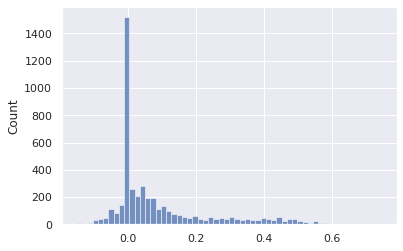

In [23]:
sns.histplot(list(g2.ep['weight']))

In [24]:
# Remove da rede todas as arestas em que weight > higher, conforme feito na aula 8.
def dicotomize(g, higher):
    removed = []

    for e in g.edges():
        if g.ep['weight'][e] > higher:
            removed.append(e)

    for e in removed:
        g.remove_edge(e)

In [25]:
dicotomize(g2, 0.2)

In [26]:
p = draw_gt.sfdp_layout(g2)
move_gt(g2, p)
save_gt(g2, 'example.net.gz')
r = netpixi.render('example.net.gz', infinite=True)

In [27]:
r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('weight', 1, 3)

In [30]:
#identificando core e periphery continuo

matrix = spectral.adjacency(g2)

# Além de cpnet.LowRankCore, há outras
# opções de algoritmos contínuos:
# cpnet.Rombach
# cpnet.Rossa

algorithm = cpnet.MINRES()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g2.vp['coreness'] = g2.new_vp('object')
for i, coreness in c.items():
    v = g.vertex(i)
    g2.vp['coreness'][v] = float(coreness)

In [42]:
#juntando informacoes cruciais em um df que contém cada vereador uma vez

final = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
final = final.dropna()

passed_names=[]
party_size=[]
partido=[]
ideologia=[]

for i, r in clean_df.iterrows():
    if r['vereador'] not in passed_names:
        passed_names.append(r['vereador'])
        party_size.append(r['tamanho partido'])
        partido.append(r['partido'])
        ideologia.append(r['posição política'])

final['partido'] = partido
final['tamanho partido'] = party_size
final['posição política'] = ideologia

final

,id,bipartite,nome,_x,_y,color,coreness,partido,tamanho partido,posição política
0,0,1,ABOU ANNI,0.010204,0.75,65280,0.737647,PV,7,-0.60
1,1,1,ADILSON AMADEU,0.020408,0.75,65280,0.803284,PTB,5,0.15
2,2,1,ALESSANDRO GUEDES,0.030612,0.75,65280,0.460667,PT,14,-0.30
3,3,1,ALFREDINHO,0.040816,0.75,65280,0.771508,PT,14,-0.30
4,4,1,ANDREA MATARAZZO,0.051020,0.75,65280,0.542014,PSD,6,0.30
...,...,...,...,...,...,...,...,...,...,...
92,92,1,DANIEL ANNENBERG,0.948980,0.75,65280,0.679826,PSDB,16,0.60
93,93,1,BETO DO SOCIAL,0.959184,0.75,65280,0.738417,PSDB,16,0.60
94,94,1,CELSO GIANNAZI,0.969388,0.75,65280,0.451614,PSOL,4,-0.90
95,95,1,XEXÉU TRIPOLI,0.979592,0.75,65280,1.195473,PV,7,-0.60


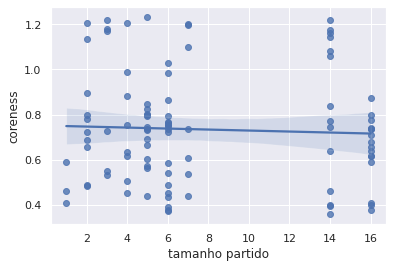

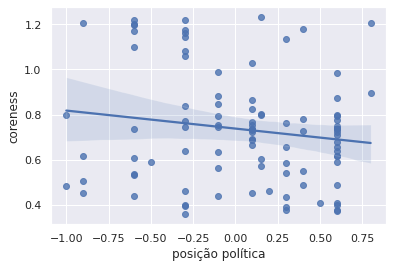

In [47]:
#regressão continua (core periphery) e continua (tamanho de partido)


sns.set()

sns.regplot(x=final['tamanho partido'], y=final['coreness'])
plt.show()
sns.regplot(x=final['posição política'], y=final['coreness'])
plt.show()